In [1]:
import pandas as pd
import numpy as np

In [2]:
dataframe = pd.read_csv('datasets/housing.csv')

In [3]:
dataframe.info

<bound method DataFrame.info of        longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  

In [4]:
dataframe['income_category'] = pd.cut(dataframe["median_income"],
                                      bins=[0,1.5,3.0,4.5,6.0,np.inf],
                                      labels=[1,2,3,4,5])

In [5]:
dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_category
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3
...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,2
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,2
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,2
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,2


In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train_stratified, test_stratified = train_test_split(dataframe, test_size=0.2, stratify = dataframe['income_category'],random_state=42)

In [8]:
for set_ in (train_stratified, test_stratified):
    set_.drop("income_category", axis=1, inplace=True)

In [9]:
train_stratified.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 12655 to 19773
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


In [10]:
housing = train_stratified.drop("median_house_value", axis=1) 
housing_labels = train_stratified["median_house_value"].copy()

In [11]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [12]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): 
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [13]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

In [14]:
housing_num = housing.drop("ocean_proximity", axis=1)
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

In [15]:
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

In [16]:
housing_prepared = full_pipeline.fit_transform(housing)

In [17]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

#param_grid = [
        #{'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
       # {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         #'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
   # ]

#svm_reg = SVR()
#grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
#grid_search.fit(housing_prepared, housing_labels)

In [18]:
 #grid_search.best_params_

In [19]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [20]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
print(lin_mse)

4709785076.060028


In [21]:
from sklearn.metrics import mean_squared_error
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018743

In [22]:
from sklearn.metrics import mean_absolute_error
lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49438.66860915801

In [23]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [24]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_mse

0.0

In [25]:
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [26]:
tree_mae = mean_absolute_error(housing_labels, housing_predictions)
tree_mae

0.0

In [27]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [28]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
Mean: 71629.89009727491
Standard deviation: 2914.035468468928


In [29]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180666


In [30]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [31]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_mse

347848562.21341085

In [32]:
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18650.698705770003

In [33]:
forest_mae = mean_absolute_error(housing_labels, housing_predictions)
forest_mae

12061.519983648257

In [34]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_crossval_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_crossval_scores)

Scores: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
Mean: 50435.58092066179
Standard deviation: 2203.3381412764606


In [35]:
from sklearn.model_selection import cross_val_score

tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
tree_rmse_crossval_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_crossval_scores)

Scores: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
Mean: 71629.89009727491
Standard deviation: 2914.035468468928


In [36]:
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
lin_rmse_crossval_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_crossval_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180666


In [37]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear",C= 30000.0)
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_mse

4922257565.859142

In [38]:
svm_rmse = np.sqrt(svm_mse)
svm_rmse

70158.80248307508

In [39]:
svm_mae = mean_absolute_error(housing_labels, housing_predictions)
svm_mae

48011.63088323751

In [40]:
metrics = {
    'Linear Regression': {'RMSE': lin_rmse, 'MAE': lin_mae},
    'Decision Tree': {'RMSE': tree_rmse, 'MAE': tree_mae},
    'Random Forest': {'RMSE': forest_rmse, 'MAE': forest_mae},
    'SVR': {'RMSE': svm_rmse, 'MAE':svm_mae}
}

In [41]:
metrics_dataframe = pd.DataFrame(metrics).T

In [42]:
metrics_dataframe

,RMSE,MAE
Linear Regression,68627.873900,49438.668609
Decision Tree,0.000000,0.000000
Random Forest,18650.698706,12061.519984
SVR,70158.802483,48011.630883


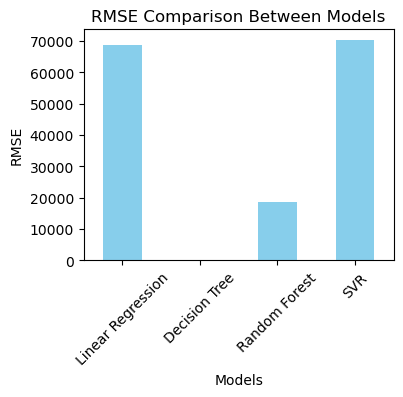

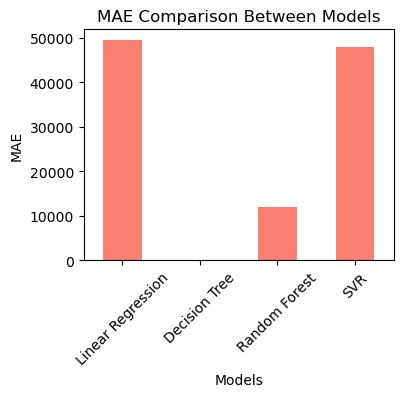

In [43]:
import matplotlib.pyplot as plt

# Plot histogram for RMSE
plt.figure(figsize=(4, 3))
metrics_dataframe['RMSE'].plot(kind='bar', color='skyblue')
plt.title('RMSE Comparison Between Models')
plt.ylabel('RMSE')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.show()

# Plot histogram for MAE
plt.figure(figsize=(4, 3))
metrics_dataframe['MAE'].plot(kind='bar', color='salmon')
plt.title('MAE Comparison Between Models')
plt.ylabel('MAE')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.show()


In [44]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
svm_rmse_crossval_scores = np.sqrt(-scores)

In [45]:
display_scores(svm_rmse_crossval_scores)

Scores: [72585.99458414 66004.56577084 67153.96597477 70209.98375934
 67114.11045891 73913.7945411  77198.45823317 69982.70788644
 67526.4418591  70919.95243819]
Mean: 70260.9975506008
Standard deviation: 3354.7386899231547


In [46]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_crossval_scores = np.sqrt(-scores)
display_scores(tree_rmse_crossval_scores)

Scores: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
Mean: 71629.89009727491
Standard deviation: 2914.035468468928


In [47]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
lin_rmse_crossval_scores = np.sqrt(-scores)
display_scores(lin_rmse_crossval_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180666


In [48]:
metrics = {
    'Linear Regression': {'RMSE': lin_rmse_crossval_scores},
    'Decision Tree': {'RMSE': tree_rmse_crossval_scores},
    'Random Forest': {'RMSE': forest_rmse_crossval_scores},
    'SVR': {'RMSE': svm_rmse_crossval_scores}
}

In [49]:
metrics_crossval_dataframe = pd.DataFrame(metrics).T

In [50]:
metrics_crossval_dataframe

,RMSE
Linear Regression,"[71762.76364394206, 64114.991663591, 67771.171..."
Decision Tree,"[72831.45749112035, 69973.18438321643, 69528.5..."
Random Forest,"[51559.633796383074, 48737.571000620606, 47210..."
SVR,"[72585.99458414373, 66004.56577084205, 67153.9..."


In [51]:
from sklearn.model_selection import cross_val_score

forest_crossval_mae_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_absolute_error", cv=10)
##forest_crossval_mae_scores = np.sqrt(-forest_crossval_scores)
display_scores(forest_crossval_mae_scores)

Scores: [-33037.9203632  -32177.03276029 -31584.31981829 -33503.8757662
 -31480.77631738 -33748.03454876 -33556.8454573  -33298.50469412
 -31743.14007268 -34154.43012114]
Mean: -32828.487991936796
Standard deviation: 939.2430190479434


In [52]:
from sklearn.model_selection import cross_val_score

lin_crossval_mae_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_absolute_error", cv=10)
##lin_crossval_mae_scores = np.sqrt(-lin_crossval_scores)
display_scores(lin_crossval_mae_scores)

Scores: [-51073.67938047 -47490.83379082 -47437.63430472 -49748.46418451
 -48317.02647654 -51366.01862714 -50783.2612851  -50614.66978571
 -48036.16866435 -50766.6692612 ]
Mean: -49563.44257605543
Standard deviation: 1493.5195373248425


In [53]:
from sklearn.model_selection import cross_val_score

tree_crossval_mae_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_absolute_error", cv=10)
##tree_crossval_mae_scores = np.sqrt(-tree_crossval_scores)
display_scores(tree_crossval_mae_scores)

Scores: [-45515.89830508 -45545.68159806 -43856.73712901 -46163.52089643
 -43769.68988492 -50604.04966687 -45249.04360993 -46169.99576015
 -44007.61538462 -44469.14778922]
Mean: -45535.13800242864
Standard deviation: 1896.7762983750138


In [54]:
from sklearn.model_selection import cross_val_score

svm_crossval_mae_scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_absolute_error", cv=10)
##svm_crossval_mae_scores = np.sqrt(-svm_crossval_scores)
display_scores(svm_crossval_mae_scores)

Scores: [-49290.7895542  -46754.91094914 -45446.89219078 -48693.27863044
 -46444.8067437  -50071.96085742 -49787.06138198 -49155.08539675
 -46451.63437088 -48991.40277627]
Mean: -48108.7822851554
Standard deviation: 1572.1583065695131


In [55]:
metrics = {
    'Linear Regression': {'RMSE': lin_rmse_crossval_scores.mean(), 'MAE': -lin_crossval_mae_scores.mean()},
    'Decision Tree': {'RMSE': tree_rmse_crossval_scores.mean(), 'MAE': -tree_crossval_mae_scores.mean()},
    'Random Forest': {'RMSE': forest_rmse_crossval_scores.mean(), 'MAE': -forest_crossval_mae_scores.mean()},
    'SVR': {'RMSE': svm_rmse_crossval_scores.mean(), 'MAE': -svm_crossval_mae_scores.mean()}
}

In [56]:
metrics_crossval_dataframe = pd.DataFrame(metrics).T

In [57]:
metrics_crossval_dataframe

,RMSE,MAE
Linear Regression,69104.079982,49563.442576
Decision Tree,71629.890097,45535.138002
Random Forest,50435.580921,32828.487992
SVR,70260.997551,48108.782285


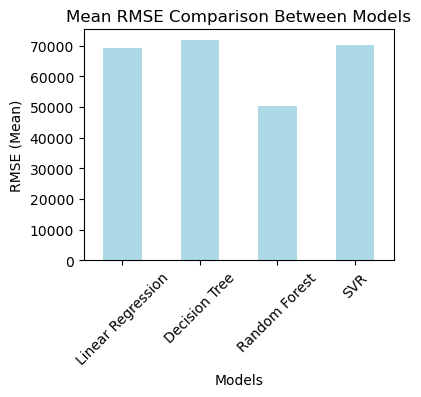

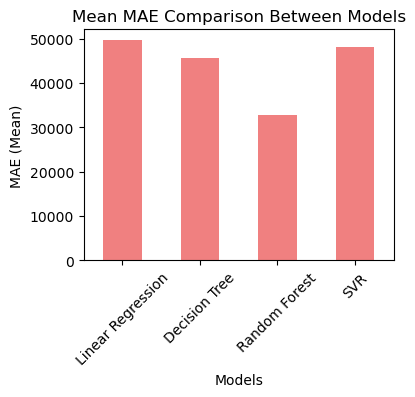

In [58]:
import matplotlib.pyplot as plt

# Plot histogram for RMSE
plt.figure(figsize=(4, 3))
metrics_crossval_dataframe['RMSE'].plot(kind='bar', color='lightblue')
plt.title('Mean RMSE Comparison Between Models')
plt.ylabel('RMSE (Mean)')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.show()

# Plot histogram for MAE
plt.figure(figsize=(4, 3))
metrics_crossval_dataframe['MAE'].plot(kind='bar', color='lightcoral')
plt.title('Mean MAE Comparison Between Models')
plt.ylabel('MAE (Mean)')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.show()

